In [84]:
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.figsize": (6, 4)})
sns.set_context('talk')

In [85]:
low_ah = pd.read_csv('low-ah.csv', index_col=0)
normal_ah = pd.read_csv('normal-ah.csv', index_col=0)

def filter_t(df):
    return (df['battery_temp_avg'] >= 0) & (df['battery_temp_avg'] <= 10)
# Reduce to similar sample T.
low_ah = low_ah[filter_t(low_ah)]
normal_ah = normal_ah[filter_t(normal_ah)]

if len(low_ah) < len(normal_ah):
    normal_ah = normal_ah.sample(n=len(low_ah), random_state=0)
elif len(low_ah) > len(normal_ah):
    low_ah = low_ah.sample(n=len(normal_ah), random_state=0)
    

print(len(low_ah), len(normal_ah), low_ah.columns)
low_ah.head(1)

(1578, 1578, Index([u'acc_mean', u'acc_pedal_pst_mean', u'acc_pedal_pst_p99',
       u'acc_pedal_pst_std', u'acc_std', u'ah_charged', u'ah_consumption',
       u'ah_discharged', u'ah_throughput', u'battery_temp_avg',
       u'battery_temp_diff_mean', u'battery_temp_diff_p1',
       u'battery_temp_diff_p99', u'battery_temp_diff_ratio_gt_10',
       u'battery_temp_diff_ratio_gt_15', u'battery_temp_diff_ratio_gt_5',
       u'battery_temp_diff_std', u'battery_temp_max_mean',
       u'battery_temp_max_p1', u'battery_temp_max_p99',
       u'battery_temp_max_std', u'battery_temp_min_mean',
       u'battery_temp_min_p1', u'battery_temp_min_p99',
       u'battery_temp_min_std', u'battery_temp_ratio_gt_35',
       u'battery_temp_ratio_gt_40', u'battery_temp_ratio_gt_45',
       u'battery_temp_ratio_gt_50', u'brake_pedal_pst_mean',
       u'brake_pedal_pst_p99', u'brake_pedal_pst_std', u'cell_volt_diff_mean',
       u'cell_volt_diff_p1', u'cell_volt_diff_p99', u'cell_volt_diff_std',
       u'coun

,acc_mean,acc_pedal_pst_mean,acc_pedal_pst_p99,acc_pedal_pst_std,acc_std,ah_charged,ah_consumption,ah_discharged,ah_throughput,battery_temp_avg,...,speed_p1,speed_p99,speed_std,start_latitude,start_longitude,start_odometer,start_soc,start_time,vin,day
3647,0.03002,0.0,0.0,0.0,0.892965,2.330533,43.443905,45.774438,48.10497,8.983827,...,0.0,78.697,20.872129,36.312808,112.880916,2990,97.0,2017-12-28 17:07:15,LMGHP1S55H1000606,2017-12-29


In [86]:
low_ah.battery_temp_min_mean.describe()

count    1578.000000
mean        4.185460
std         2.062902
min        -8.953368
25%         2.903682
50%         4.049929
75%         5.433720
max         9.724970
Name: battery_temp_min_mean, dtype: float64

In [87]:
def mk_distplot(col):
    fig, ax = plt.subplots(1)
    
    X = low_ah[col].values
    Y = normal_ah[col].values
    
    # Remove outliers for this plot:
    X = X[np.where((X > np.percentile(X, 1)) & (X < np.percentile(X, 99)))]
    Y = Y[np.where((Y > np.percentile(Y, 1)) & (Y < np.percentile(Y, 99)))]
    
    sns.distplot(X, label='low Ah', ax=ax)
    sns.distplot(Y, label='normal Ah', ax=ax)
    ax.set_xlabel(col)
    ax.legend(loc=0)
    sns.despine()
    

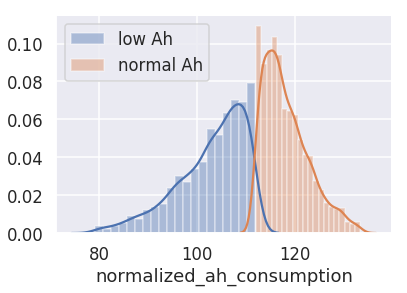

In [88]:
col = 'normalized_ah_consumption'
mk_distplot(col)

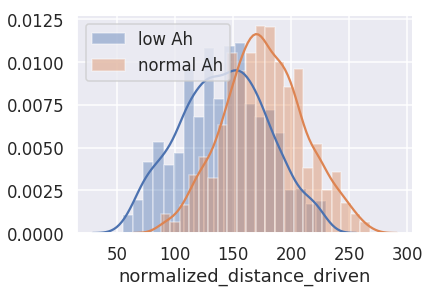

In [89]:
col = 'normalized_distance_driven'
mk_distplot(col)

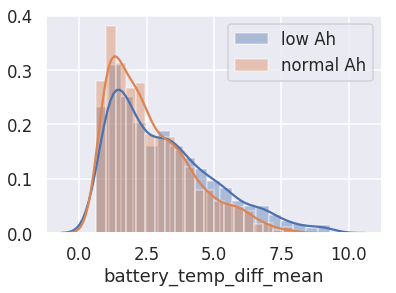

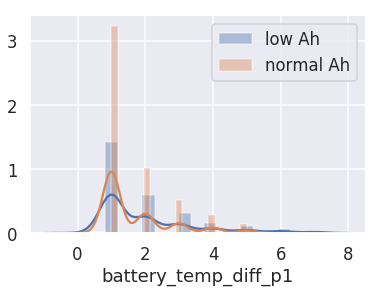

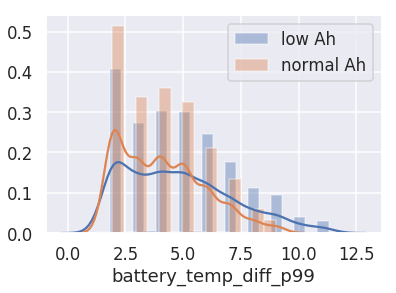

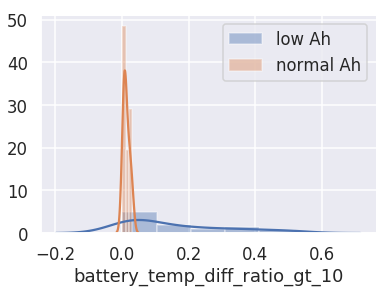

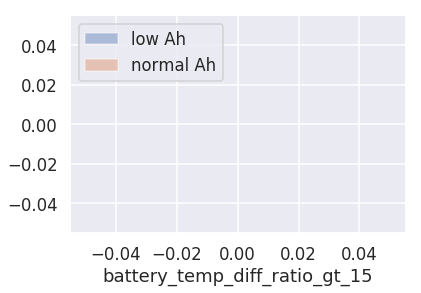

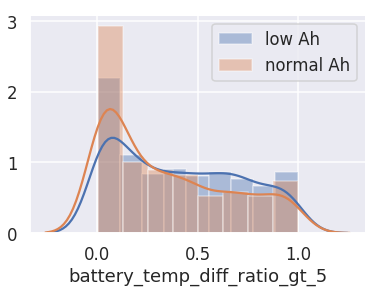

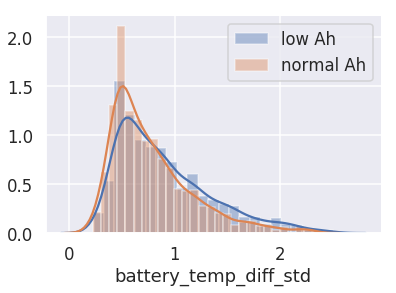

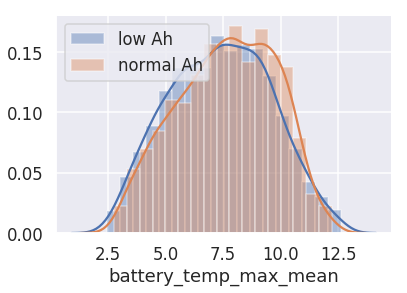

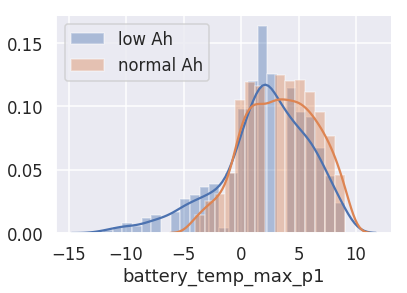

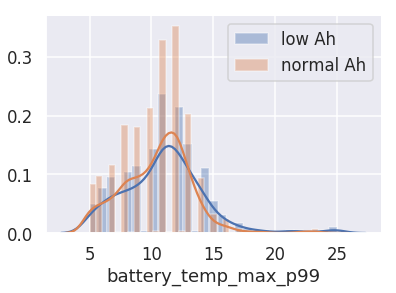

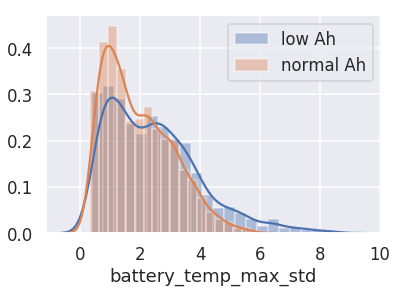

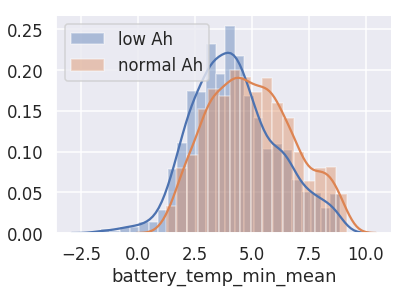

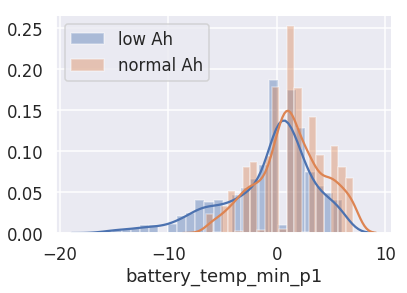

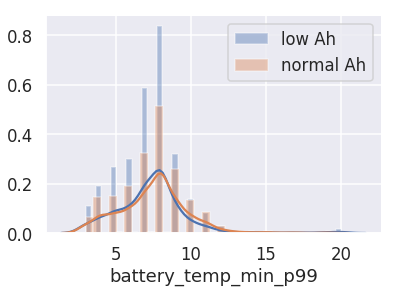

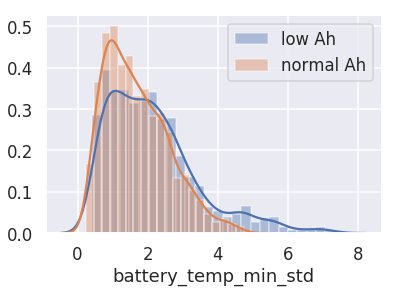

In [90]:
cols = ['battery_temp_diff_mean', 'battery_temp_diff_p1',
       'battery_temp_diff_p99', 'battery_temp_diff_ratio_gt_10',
       'battery_temp_diff_ratio_gt_15', u'battery_temp_diff_ratio_gt_5',
       'battery_temp_diff_std', 'battery_temp_max_mean',
       'battery_temp_max_p1', 'battery_temp_max_p99',
       'battery_temp_max_std', 'battery_temp_min_mean',
       'battery_temp_min_p1', 'battery_temp_min_p99',
       'battery_temp_min_std']

for col in cols:
    mk_distplot(col)

In [96]:
# Get CDF functions:

from scipy.stats import norm
from scipy.special import kolmogorov
from scipy.interpolate import interp1d

def apply_kolmogorov_test(X, Y):
    # Get CDF for X, this may not be the most effective or elegant way to do this:
    percentiles = np.linspace(0 , 1, 1000) * 100.0
    CDF_X=[]; CDF_Y=[]; X_vals=[]; Y_vals=[]
   

    # Remove outliers for this test:
    X = X[np.where((X > np.percentile(X, 1)) & (X < np.percentile(X, 99)))]
    Y = Y[np.where((Y > np.percentile(Y, 1)) & (Y < np.percentile(Y, 99)))]

    if (X.size == 0 ) or (Y.size == 0):
        return None, None, None, None, None
    
    # Add extreme values with p=0
    cdf = 0; x = X.min() - X.max() * 1000
    CDF_X.append(cdf); X_vals.append(x)
    cdf = 0; x = Y.min() - Y.max() * 1000
    CDF_Y.append(cdf); Y_vals.append(x)
    
    for percentile in percentiles:
        #
        cdf = percentile / 100
        x = np.percentile(X, percentile)
        y = np.percentile(Y, percentile)
        CDF_X.append(cdf)
        X_vals.append(x)
        CDF_Y.append(cdf)
        Y_vals.append(y)
    
    # Add extreme values with p=1
    cdf = 1.0; x = X.max() + X.max() * 1000
    CDF_X.append(cdf); X_vals.append(x)
    cdf = 1.0; x = Y.max() + Y.max() * 1000
    CDF_Y.append(cdf); Y_vals.append(x)
    
    CDF_X = np.array(CDF_X)
    CDF_Y = np.array(CDF_Y)
    Y_vals = np.array(Y_vals)
    X_vals = np.array(X_vals)
 
    # Now that we have computed CDF_X and CDF_Y for discrete set of values, we need to make them continuous functions
    def f(x):
        ff = interp1d(X_vals, CDF_X, kind='linear')
        return ff(x)
    
    def g(x):
        gg = interp1d(Y_vals, CDF_Y, kind='linear')
        return gg(x)
        
    # Evaluate CDF functions for a discrete number of samples and get maximum diff:   
    x = np.linspace(max(np.min(X), np.min(Y)), min(np.max(X), np.max(Y)), 10000)
    
    # Get the maximum distance between the two distributions:
    diff = np.abs(f(x) - g(x))
    KS_statistic = diff.max()
    # Get the index for the max. between the two distributions, for plotting
    KS_index = x[diff.argmax()]


    # Get the pvalue from the corresonding scipy function:
    # https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.special.kolmogorov.html
    pvalue = kolmogorov(np.sqrt(len(X))*KS_statistic)
    
    return f, g, KS_statistic, KS_index, pvalue

def plot_kolmogorov_test(x, CDF_X, CDF_Y, KS_index, col):


    fig, ax = plt.subplots()
    
    ax.plot(x, CDF_X(x), color='blue', linestyle='-', lw=5, alpha=0.6, label = 'low Ah' )
    ax.plot(x, CDF_Y(x), color='orange', linestyle='-', lw=5, alpha=0.6, label = 'normal Ah')

    #ax.axvline(KS_index)
    ax.plot([KS_index, KS_index], [CDF_X(KS_index), CDF_Y(KS_index)], color='b', linestyle='-', linewidth=2)
    
    ax.text(KS_index, 0.5, r'Max. diff.',color='b')

    #plt.ylim(0,1)

    ax.legend(loc=0)
    ax.set_ylabel('CDF')
    ax.set_xlabel(col)

    sns.despine()

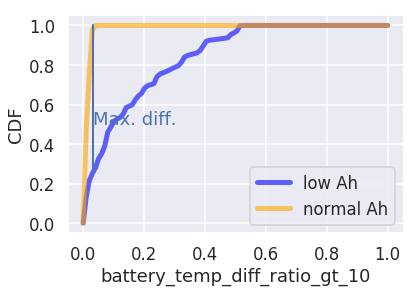

In [97]:
col = 'battery_temp_diff_ratio_gt_10'
#col = 'battery_temp_diff_p99'
X = low_ah[col].values
Y = normal_ah[col].values
CDF_X, CDF_Y, KS_statistic, KS_index, pvalue = apply_kolmogorov_test(X, Y)
x = np.linspace(min(X.min(), Y.min()), max(X.max(), Y.max()), 100)
plot_kolmogorov_test(x, CDF_X, CDF_Y, KS_index, col)



,ks_statistic,pvalue
column,,
battery_temp_diff_ratio_gt_10,0.740745,7.008353e-32
battery_temp_diff_p1,0.279677,9.655614e-78
battery_temp_diff_p99,0.226416,3.235617e-67
battery_temp_min_p1,0.214669,5.010909e-61
battery_temp_max_p1,0.185316,1.883099e-46
battery_temp_min_mean,0.178028,5.510440e-43
battery_temp_min_std,0.145920,5.109418e-29
battery_temp_max_std,0.145536,7.223970e-29
battery_temp_diff_ratio_gt_5,0.127177,1.486049e-10


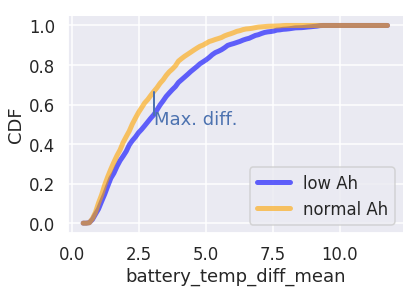

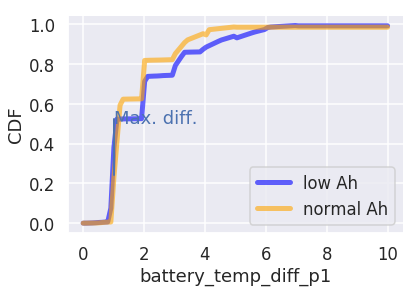

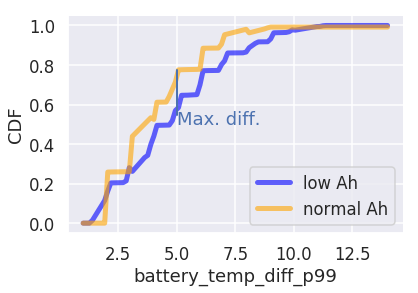

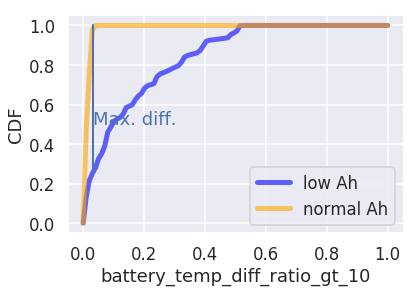

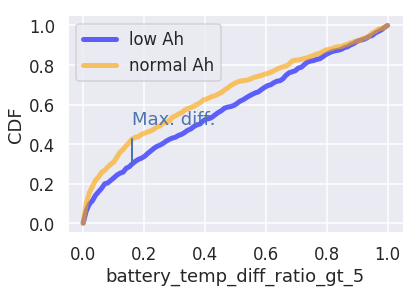

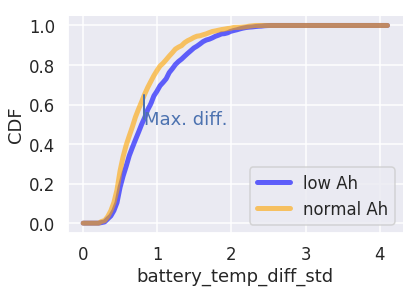

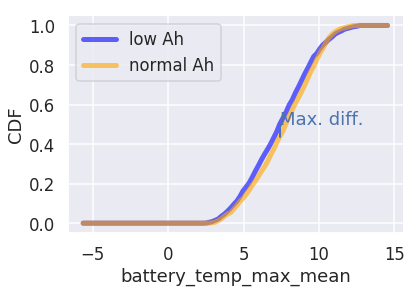

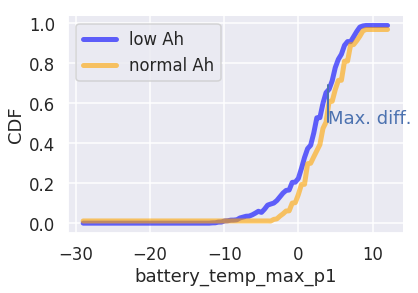

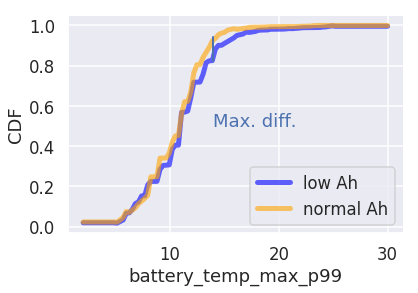

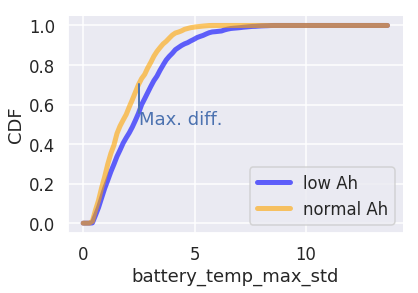

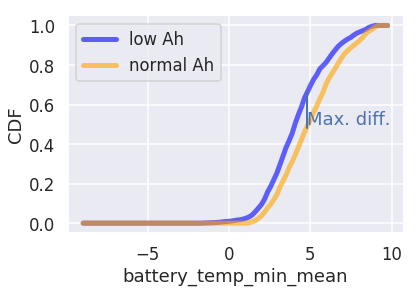

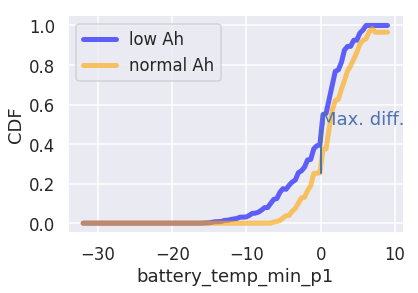

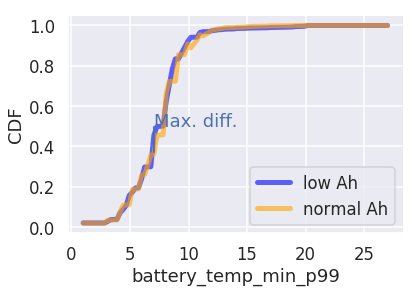

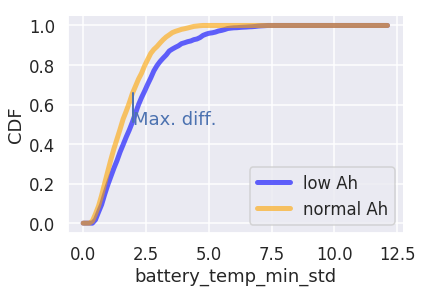

In [98]:
test_distribution_diff = []
for col in cols:
    X = low_ah[col].values
    Y = normal_ah[col].values
    CDF_X, CDF_Y, KS_statistic, KS_index, pvalue = apply_kolmogorov_test(X, Y)
    
    if CDF_X:
        test_distribution_diff.append(
            {
                'column' : col,
                'ks_statistic' : KS_statistic,
                'pvalue' : pvalue
            }
        )
        x = np.linspace(min(X.min(), Y.min()), max(X.max(), Y.max()), 100)
        plot_kolmogorov_test(x, CDF_X, CDF_Y, KS_index, col)
    
test_distribution_diff = pd.DataFrame(test_distribution_diff)
test_distribution_diff.sort_values(by='ks_statistic', ascending=False, inplace=True)
test_distribution_diff.set_index('column', inplace=True)
test_distribution_diff